In [1]:
tickers = ["AMZN", "TSLA", "BABA", "HD", "TM", "NKE", "MCD", "LOW", "SBUX", "JD", "PDD", "BKNG", "GM", "MELI", "TJX", "NIO", "F", "LULU", "HMC", "CMG"]

In [2]:

!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



    thresh = cm.numpy().max() / 1.5 if normalize else cm.numpy().max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

First, let us try to train on a simple dense model

In [4]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


In [5]:
def create_model(shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=14))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='sparse_categorical_crossentropy')
    return model


In [49]:
from sklearn.model_selection import train_test_split
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"


random_tickers_to_train_on = np.random.choice(tickers, size=5, replace=False)


for ticker in random_tickers_to_train_on:
    data = pd.read_csv(f'./data_with_labels/{ticker}_with_labels.csv')
    features, labels = data.drop(['policy', 'Date'], axis=1).to_numpy(), data['policy'].to_numpy()

    enc = OneHotEncoder(handle_unknown='ignore')
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)
    enc_ytrain_labels = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
    enc_ytest_labels = enc.fit_transform(y_test.reshape(-1, 1)).toarray()

    
    model = create_model(shape = X_train.shape)
    history = model.fit(X_train, enc_ytrain_labels, epochs=20, batch_size=16, verbose=1, validation_data=(X_test, enc_ytest_labels))
    
    loss, accuracy, mse = model.evaluate(X_test, enc_ytest_labels, batch_size=16, verbose=1)
    
    y_pred = model.predict(X_test)
    print(y_pred)
    y_pred = np.argmax(y_pred, axis=1)
    print(f"Confusion Matrix for {ticker}")
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, np.arange(4))

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



    print(classification_report(y_test, y_pred, zero_division=0))
    

AttributeError: 'numpy.ndarray' object has no attribute 'values'

Then let's try a more complex model

In [30]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
    for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array
    
def create_model_LSTM(shape):
    model = Sequential()
    #model.add(Reshape((1, 14), input_shape=(5,14)))
    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='tanh'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    return model


Epoch 1/10
60/60 [==============================] - 5s 38ms/step - loss: 1.4153 - accuracy: 0.2673 - mse: 0.1903 - val_loss: 1.3833 - val_accuracy: 0.2848 - val_mse: 0.1870
Epoch 2/10
60/60 [==============================] - 1s 21ms/step - loss: 1.3852 - accuracy: 0.2927 - mse: 0.1874 - val_loss: 1.3727 - val_accuracy: 0.3312 - val_mse: 0.1858
Epoch 3/10
60/60 [==============================] - 1s 22ms/step - loss: 1.3788 - accuracy: 0.2863 - mse: 0.1865 - val_loss: 1.3739 - val_accuracy: 0.3333 - val_mse: 0.1859
Epoch 4/10
60/60 [==============================] - 1s 21ms/step - loss: 1.3812 - accuracy: 0.2768 - mse: 0.1869 - val_loss: 1.3793 - val_accuracy: 0.2932 - val_mse: 0.1866
Epoch 5/10
60/60 [==============================] - 1s 21ms/step - loss: 1.3762 - accuracy: 0.2884 - mse: 0.1862 - val_loss: 1.3784 - val_accuracy: 0.3143 - val_mse: 0.1866
Epoch 6/10
60/60 [==============================] - 1s 22ms/step - loss: 1.3734 - accuracy: 0.3001 - mse: 0.1859 - val_loss: 1.3791 - v

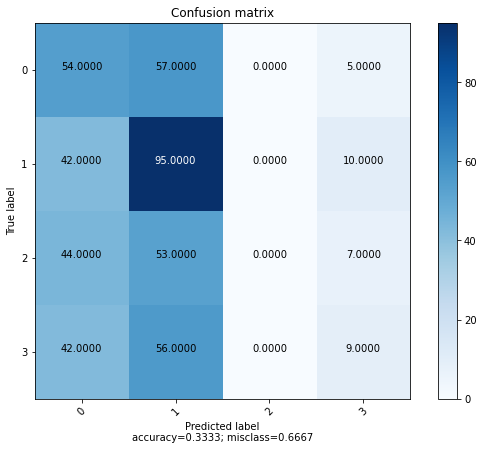

              precision    recall  f1-score   support

         0.0       0.30      0.47      0.36       116
         1.0       0.36      0.65      0.47       147
         2.0       0.00      0.00      0.00       104
         3.0       0.29      0.08      0.13       107

    accuracy                           0.33       474
   macro avg       0.24      0.30      0.24       474
weighted avg       0.25      0.33      0.26       474

Epoch 1/10
60/60 [==============================] - 3s 32ms/step - loss: 1.3549 - accuracy: 0.3761 - mse: 0.1831 - val_loss: 1.3319 - val_accuracy: 0.3861 - val_mse: 0.1804
Epoch 2/10
60/60 [==============================] - 1s 22ms/step - loss: 1.3360 - accuracy: 0.3867 - mse: 0.1808 - val_loss: 1.3371 - val_accuracy: 0.3861 - val_mse: 0.1812
Epoch 3/10
60/60 [==============================] - 1s 23ms/step - loss: 1.3404 - accuracy: 0.3867 - mse: 0.1812 - val_loss: 1.3314 - val_accuracy: 0.3861 - val_mse: 0.1804
Epoch 4/10
13/60 [=====>......................

KeyboardInterrupt: 

In [32]:
from sklearn.model_selection import train_test_split
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"


random_tickers_to_train_on = np.random.choice(tickers, size=5, replace=False)


for ticker in random_tickers_to_train_on:
    data = pd.read_csv(f'./data_with_labels/{ticker}_with_labels.csv')
    features, labels = data.drop(['policy', 'Date'], axis=1), data['policy']

    enc = OneHotEncoder(handle_unknown='ignore')

    features, labels = lstm_data_transform(features, labels)
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)
    enc_ytrain_labels = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
    enc_ytest_labels = enc.transform(y_test.reshape(-1, 1)).toarray()

    
    model = create_model_LSTM(shape = X_train.shape)
    model.fit(X_train, enc_ytrain_labels, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, enc_ytest_labels))


    loss, accuracy, mse = model.evaluate(X_test, enc_ytest_labels, batch_size=16, verbose=1)
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"Confusion Matrix for {ticker}")
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, np.arange(4))
    print(classification_report(y_test, y_pred, zero_division=0))
    